# ML Workbench Sample --- Image Classification

<br><br>
### _Introduction of ML Workbench_
ML Workbench provides an easy command line interface for machine learning life cycle, which involves four stages:
* analyze: gather stats and metadata of the training data, such as numeric stats, vocabularies, etc. Analysis results are used in transforming raw data into numeric features, which can be consumed by training directly.  
* transform: explicitly transform raw data into numeric features which can be used for training.
* train: training model using transformed data.
* predict/batch_predict: given a few instances of prediction data, make predictions instantly / with large number of instances of prediction data, make predictions in a batched fassion.


There are "local" and "cloud" run mode for each stage. "cloud" run mode is recommended if your data is big.
<br><br>
ML Workbench supports numeric, categorical, text, image training data. For each type, there are a set of "transforms" to choose from. The "transforms" indicate how to convert the data into numeric features. For images, it is converted to fixed size vectors representing high level features.
<br><br>

### _Transfer learning using Inception Package - Cloud Run Experience_
ML Workbench supports image transforms (image to vec) with transfer learning.

This notebook continues the codifies the capabilities discussed in this [blog post](http://localhost:8081/). In a nutshell, it uses the pre-trained inception model as a starting point and then uses transfer learning to train it further on additional, customer-specific images. For explanation, simple flower images are used. Compared to training from scratch, the time and costs are drastically reduced.

This notebook does preprocessing, training and prediction by calling CloudML API instead of running them in the Datalab container.  The purpose of local work is to do some initial prototyping and debugging on small scale data - often by taking a suitable (say 0.1 - 1%) sample of the full data. The same basic steps can then be repeated with much larger datasets in cloud.

In [2]:
# ML Workbench magics (%%ml) are under google.datalab.contrib namespace. It is not enabled by default and you need to import it before use.
import google.datalab.contrib.mlworkbench.commands

# Setup

In [1]:
bucket = 'gs://' + datalab_project_id() + '-lab'
analysis_dir = bucket + '/flower/analysis'
transform_dir = bucket + '/flower/transform'
transformed_train = bucket + '/flower/transform/train-*'
transformed_eval = bucket + '/flower/transform/eval-*'
model_dir = bucket + '/flower/model'
prediction_model_dir = model_dir + '/model'
evaluation_model_dir = model_dir + '/evaluation_model'
staging_dir = bucket + '/staging'
evaluation_data_source = bucket + '/eval/eval_image_embedded-*'
prediction_output_dir = bucket + '/predict'
prediction_results_files = bucket + '/predict/prediction.results*'

In [8]:
# Create a GCS bucket as our working directory
!gsutil mb $bucket

Creating gs://datalab-demo-project-lab/...
ServiceException: 409 Bucket datalab-demo-project-lab already exists.


# Analyze

Analysis step includes computing numeric stats (i.e. min/max), categorical classes, text vocabulary and frequency, etc. Run "%%ml analyze --help" for usage. The analysis results will be used for transforming raw data into numeric features that the model can deal with. For example, to convert categorical value to a one-hot vector ("Monday" becomes [1, 0, 0, 0, 0, 0, 0]). The data may be very large, so sometimes a cloud run is needed by adding --cloud flag. Cloud run will start BigQuery jobs, which may incur some costs.

In this case, analysis step only collects unique labels.

Note that we run analysis only on training data, but not evaluation data.

In [4]:
%%ml analyze --cloud
output: $analysis_dir 
training_data:
    csv: gs://cloud-datalab/sampledata/flower/train3000.csv
    schema:
        - name: image_url
          type: STRING
        - name: label
          type: STRING
features:
    image_url:
        transform: image_to_vec
    label:
        transform: target

Analyzing column image_url...
column image_url analyzed.
Analyzing column label...
column label analyzed.
Updated property [core/project].


In [ ]:
# Check analysis results
!gsutil list $analysis_dir

# Transform

With analysis results we can transform raw data into numeric features. This needs to be done for both training and eval data. The data may be very large, so sometimes a cloud pipeline is needed by adding --cloud. Cloud run is implemented by DataFlow jobs, so it may incur some costs.

In this case, transform is required. It downloads image, resizes it, and generate embeddings from each image by running a pretrained TensorFlow graph.

In [ ]:
# Remove previous results
!gsutil -m rm {transformed_train}
!gsutil -m rm {transformed_eval}

In [9]:
%%ml transform --cloud
analysis: $analysis_dir
prefix: train
output: $transform_dir
training_data:
    csv: gs://cloud-datalab/sampledata/flower/train3000.csv
cloud_config:
    job_name: mltoolbox-image-transform-train

/usr/local/lib/python2.7/dist-packages/apache_beam/io/gcp/gcsio.py:113: DeprecationWarning: object() takes no parameters
  super(GcsIO, cls).__new__(cls, storage_client))
/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)
running sdist
running egg_info
creating trainer.egg-info
writing requirements to trainer.egg-info/requires.txt
writing trainer.egg-info/PKG-INFO
writing top-level names to trainer.egg-info/top_level.txt
writing dependency_links to trainer.egg-info/dependency_links.txt
writing manifest file 'trainer.egg-info/SOURCES.txt'
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'

running check

creating trainer-1.0.0
creating trainer-1.0.0/trainer
creating trainer-1.0.0/trainer.egg-info
making hard links in trainer-1.0.0...
hard linking setup.py -> trainer-1.0.0
hard linking tr

In [10]:
%%ml transform --cloud
analysis: $analysis_dir
prefix: eval
output: $transform_dir
training_data:
    csv: gs://cloud-datalab/sampledata/flower/eval670.csv
cloud_config:
    job_name: mltoolbox-image-transform-eval

/usr/local/lib/python2.7/dist-packages/apache_beam/io/gcp/gcsio.py:113: DeprecationWarning: object() takes no parameters
  super(GcsIO, cls).__new__(cls, storage_client))
/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)
running sdist
running egg_info
writing requirements to trainer.egg-info/requires.txt
writing trainer.egg-info/PKG-INFO
writing top-level names to trainer.egg-info/top_level.txt
writing dependency_links to trainer.egg-info/dependency_links.txt
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'

running check

creating trainer-1.0.0
creating trainer-1.0.0/trainer
creating trainer-1.0.0/trainer.egg-info
making hard links in trainer-1.0.0...
hard linking setup.py -> trainer-1.0.0
hard linking trainer/__init__.py -> trainer-1.0.0/trainer
hard linking trainer/feature_transfo

In [7]:
!gsutil list -l -h $transform_dir

       0 B  2017-07-14T20:13:32Z  gs://datalab-demo-project-lab/flower/transform/errors_eval-00000-of-00001.txt
       0 B  2017-07-14T20:08:59Z  gs://datalab-demo-project-lab/flower/transform/errors_train-00000-of-00001.txt
 36.28 KiB  2017-07-14T20:13:43Z  gs://datalab-demo-project-lab/flower/transform/eval-00000-of-00007.tfrecord.gz
  1.56 MiB  2017-07-14T20:13:43Z  gs://datalab-demo-project-lab/flower/transform/eval-00001-of-00007.tfrecord.gz
151.23 KiB  2017-07-14T20:13:43Z  gs://datalab-demo-project-lab/flower/transform/eval-00002-of-00007.tfrecord.gz
390.11 KiB  2017-07-14T20:13:43Z  gs://datalab-demo-project-lab/flower/transform/eval-00003-of-00007.tfrecord.gz
114.67 KiB  2017-07-14T20:13:43Z  gs://datalab-demo-project-lab/flower/transform/eval-00004-of-00007.tfrecord.gz
  1.58 MiB  2017-07-14T20:13:44Z  gs://datalab-demo-project-lab/flower/transform/eval-00005-of-00007.tfrecord.gz
 914.2 KiB  2017-07-14T20:13:43Z  gs://datalab-demo-project-lab/flower/transform/eval-00006-of-00

# Train

Training starts from transformed data. If training work is too much to do on the local VM, --cloud is recommended so training happens in cloud, in a distributed way. Run %%ml train --help for details.

Training in cloud is implemented with Cloud ML Engine. It may incur some costs.

In [ ]:
# Remove previous training results.
!gsutil -m rm -r $model_dir 

In [15]:
%%ml train --cloud
output: $model_dir 
analysis: $analysis_dir
training_data:
    transformed: $transformed_train
evaluation_data:
    transformed: $transformed_eval
model_args:
    model: dnn_classification
    train-batch-size: 100
    eval-batch-size: 100
    hidden-layer-size1: 100
    max-steps: 3000
    top-n: 2
cloud_config:
    region: us-central1
    scale_tier: BASIC

Job "trainer_task_170714_202547" submitted. Click here to view cloud log.

In [9]:
# Start a tensorboard hosted in Datalab. Note that because model_dir is a GCS path, you may not see data immediately after
# Tensorboard is started. Wait for one minute and maybe refresh the Tensorboard page and the data will likely appear.

from google.datalab.ml import TensorBoard

TensorBoard.start(model_dir);

TensorBoard was started successfully with pid 1198. Click here to access it.

# Prediction

There are two types of prediction: instant and batch. Instant prediction works for small instances of data and the results come back instantly. The prediction data is provided in http request for cloud run.

Instant prediction in cloud is implemented with Google Cloud ML Engine so it may incur some costs.

In [10]:
# List the model files
!gsutil list $prediction_model_dir 

gs://datalab-demo-project-lab/flower/model/model/
gs://datalab-demo-project-lab/flower/model/model/saved_model.pb
gs://datalab-demo-project-lab/flower/model/model/assets.extra/
gs://datalab-demo-project-lab/flower/model/model/variables/


In [4]:
# We need to deploy model before we can do online prediction.
from google.datalab.ml import Models, ModelVersions

# Note that if the model is already created, you should skip next line
Models().create('flower_model')

ModelVersions('flower_model').deploy('prediction', prediction_model_dir)

Waiting for operation "projects/datalab-demo-project/operations/create_flower_model_prediction-1500337818315"
Done.


predicted,predicted_2,score,score_2,flower,flower_image
sunflowers,dandelion,1.000000,5.184184e-08,gs://cloud-ml-data/img/flower_photos/...,
sunflowers,daisy,0.999921,4.882073e-05,gs://cloud-ml-data/img/flower_photos/...,
roses,tulips,1.000000,7.590337e-12,gs://cloud-ml-data/img/flower_photos/...,
sunflowers,dandelion,1.000000,1.361754e-10,gs://cloud-ml-data/img/flower_photos/...,
dandelion,daisy,1.000000,8.856081e-12,gs://cloud-ml-data/img/flower_photos/...,
tulips,sunflowers,0.997998,2.001649e-03,gs://cloud-ml-data/img/flower_photos/...,

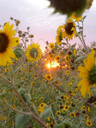
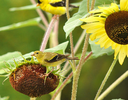
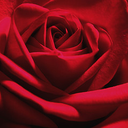
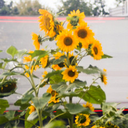
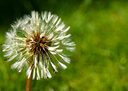
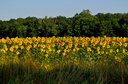

In [3]:
%%ml predict --cloud
model: flower_model.prediction
headers: flower
image_columns: flower
prediction_data:
  - gs://cloud-ml-data/img/flower_photos/sunflowers/5043409092_5b12cc985a_m.jpg
  - gs://cloud-ml-data/img/flower_photos/sunflowers/6074427492_1b5bab7848_n.jpg
  - gs://cloud-ml-data/img/flower_photos/roses/6209630964_e8de48fe04_m.jpg
  - gs://cloud-ml-data/img/flower_photos/sunflowers/15054752730_fcf54d475e_m.jpg
  - gs://cloud-ml-data/img/flower_photos/dandelion/4571923094_b9cefa9438_n.jpg
  - gs://cloud-ml-data/img/flower_photos/sunflowers/6140661443_bb48344226.jpg

# Batch Prediction

Batch prediction performs prediction in a batched fashion. The data can be large, and is specified by files.  

In this case, there is an extra thing we need to do. We need to download images and replace image urls with resized image bytes. Because the data may be large, below is a DataFlow pipeline for it. In the future, this step can be skipped and the local predictor and prediction service can do it for you but for the time being, it is required. It is only needed if you have image urls in your prediction data.

Note that, we use the "evaluation_model" which sits in "evaluation_model_dir". There are two models created in training. One is a regular model under "model" dir, the other is "evaluation_model". The difference is the regular one takes prediction data without target and the evaluation model takes data with target and output the target as is. So evaluation model is good for evaluating the quality of the model because the targets and predicted values are included in output.

In [ ]:
"""Given source CSV files as prediction/evaluation source data, convert image_url columns into image bytes by
   downloading, resizing, and converting it to bytes. The pipeline is a demo of what needs to be done
   if your prediction/evaluation data contains image url columns.
"""


import apache_beam as beam


def embed_images(csv_line, headers, image_columns):
    """Replace an images url with its jpeg bytes in a dataflow pipeline.
    Args:
        element: one input row, as a dict
        image_columns: list of columns that are image paths
    Return:
        element, where each image file path has been replaced by a base64 image.
    """
   
    import base64  
    import csv
    import cStringIO
    from PIL import Image
    import six
    from tensorflow.python.lib.io import file_io as tf_file_io
  
    r = next(csv.reader([csv_line]))
    if len(r) != len(headers):
        raise ValueError('csv line %s does not have %d columns' % (csv_line, len(headers)))

    element = {k: v for k, v in zip(headers, r)}
    
    for name in image_columns:
        uri = element[name]
        if not uri:
            continue
        try:
            with tf_file_io.FileIO(uri, 'r') as f:
                img = Image.open(f).convert('RGB')

        except Exception as e:
            logging.exception('Error processing image %s: %s', uri, str(e))
            return

        # Convert to desired format and output.
        output = cStringIO.StringIO()
        img.thumbnail((299, 299), Image.ANTIALIAS)
        img.save(output, 'jpeg')
        element[name] = base64.urlsafe_b64encode(output.getvalue())

    values = [str(element[x]) for x in headers]
    str_buff = six.StringIO()
    writer = csv.writer(str_buff, lineterminator='')
    writer.writerow(values)

    return str_buff.getvalue()


headers = ['img_url', 'label']
img_columns = ['img_url']
file_pattern = 'gs://cloud-datalab/sampledata/flower/eval670.csv'
pipeline_name = 'DataflowRunner'
options = {
    'job_name': 'embed-images-to-csv',
    'temp_location': staging_dir,
    'project': datalab_project_id(),
}
pipeline_options = beam.pipeline.PipelineOptions(flags=[], **options)
p = beam.Pipeline(pipeline_name, options=pipeline_options)
(p | 'ReadCSVFile' >> beam.io.ReadFromText(file_pattern) | 'BuildCSVString' >> beam.Map(embed_images, headers, img_columns) 
    | beam.io.WriteToText(evaluation_data_source, file_name_suffix='.csv'))
p.run().wait_until_finish()

/usr/local/lib/python2.7/dist-packages/apache_beam/io/gcp/gcsio.py:113: DeprecationWarning: object() takes no parameters
  super(GcsIO, cls).__new__(cls, storage_client))
/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)


In [6]:
!gsutil ls -l $evaluation_data_source

   4049709  2017-07-15T13:15:42Z  gs://datalab-demo-project-lab/eval/eval_image_embedded-00000-of-00003.csv
   4106946  2017-07-15T13:15:42Z  gs://datalab-demo-project-lab/eval/eval_image_embedded-00001-of-00003.csv
   4099910  2017-07-15T13:15:42Z  gs://datalab-demo-project-lab/eval/eval_image_embedded-00002-of-00003.csv
TOTAL: 3 objects, 12256565 bytes (11.69 MiB)


In [7]:
%%ml batch_predict --cloud
model: flower_model.eval
output: $prediction_output_dir
cloud_config:
    region: us-central1
prediction_data:
    csv: $evaluation_data_source

Job "prediction_170715_133309" submitted. Click here to view cloud log.

In [9]:
# after prediction is done, check the output
!gsutil list -l -h $prediction_output_dir

       0 B  2017-07-15T13:43:02Z  gs://datalab-demo-project-lab/predict/prediction.errors_stats-00000-of-00001
  6.35 KiB  2017-07-15T13:43:05Z  gs://datalab-demo-project-lab/predict/prediction.results-00000-of-00005
  9.69 KiB  2017-07-15T13:43:05Z  gs://datalab-demo-project-lab/predict/prediction.results-00001-of-00005
 27.35 KiB  2017-07-15T13:43:05Z  gs://datalab-demo-project-lab/predict/prediction.results-00002-of-00005
 11.53 KiB  2017-07-15T13:43:05Z  gs://datalab-demo-project-lab/predict/prediction.results-00003-of-00005
 27.62 KiB  2017-07-15T13:43:05Z  gs://datalab-demo-project-lab/predict/prediction.results-00004-of-00005
TOTAL: 6 objects, 84522 bytes (82.54 KiB)


In [12]:
!gsutil cat -r -200 $prediction_results_files

561019430912605e-12, "score": 1.0, "target": "tulips", "predicted": "tulips"}
{"predicted_2": "daisy", "score_2": 8.627875483149935e-16, "score": 1.0, "target": "dandelion", "predicted": "dandelion"}
61997603572784e-12, "score": 1.0, "target": "tulips", "predicted": "tulips"}
{"predicted_2": "daisy", "score_2": 5.8855031494141644e-21, "score": 1.0, "target": "dandelion", "predicted": "dandelion"}
36, "score": 0.9983799457550049, "target": "sunflowers", "predicted": "sunflowers"}
{"predicted_2": "tulips", "score_2": 1.5239456797996789e-15, "score": 1.0, "target": "roses", "predicted": "roses"}
: 1.0, "target": "dandelion", "predicted": "dandelion"}
{"predicted_2": "dandelion", "score_2": 2.5272685888921842e-05, "score": 0.9999747276306152, "target": "sunflowers", "predicted": "sunflowers"}
6e-13, "score": 1.0, "target": "dandelion", "predicted": "dandelion"}
{"predicted_2": "tulips", "score_2": 1.0691426268749638e-06, "score": 0.999998927116394, "target": "roses", "predicted": "roses"}


Prediction results are in JSON format. We can load the results into BigQuery table and performa analysis.

In [11]:
import google.datalab.bigquery as bq

schema = [
  {'name': 'predicted', 'type': 'STRING'},
  {'name': 'target', 'type': 'STRING'},
  {'name': 'predicted_2', 'type': 'STRING'},  
  {'name': 'score', 'type': 'FLOAT'},  
  {'name': 'score_2', 'type': 'FLOAT'},    
]

bq.Dataset('image_classification_results').create()
t = bq.Table('image_classification_results.flower').create(schema = schema, overwrite = True)
t.load(prediction_results_files, mode='overwrite', source_format = 'json')

Job datalab-demo-project/job_1aT05MIJKF6ciiDyIk-jDNZWhtU completed

Check wrong predictions.

In [12]:
%%bq query
SELECT * FROM image_classification_results.flower WHERE predicted != target

predicted,target,predicted_2,score,score_2
sunflowers,tulips,tulips,0.994596838951,0.00320156849921
sunflowers,roses,daisy,0.999915838242,8.41244545882e-05
roses,tulips,tulips,0.965378820896,0.0346210971475
roses,tulips,tulips,0.997135162354,0.00286464509554
roses,tulips,tulips,0.985994458199,0.013934019953
daisy,roses,sunflowers,0.972567737103,0.0273106470704
dandelion,sunflowers,sunflowers,0.727719962597,0.272278875113
tulips,roses,roses,0.99988758564,0.00011211191304
roses,daisy,dandelion,0.916075408459,0.0467615649104
dandelion,sunflowers,daisy,0.955390870571,0.0396608486772


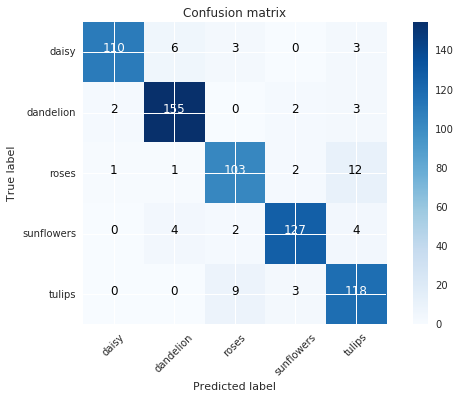

In [13]:
# Draw a confusion matrix using BigQuery.

from google.datalab.ml import ConfusionMatrix

cm = ConfusionMatrix.from_bigquery('image_classification_results.flower')
cm.plot()

Compute accuracy.

In [6]:
%%bq query

SELECT
  target,
  SUM(CASE WHEN target=predicted THEN 1 ELSE 0 END) as correct,
  COUNT(*) as total,
  SUM(CASE WHEN target=predicted THEN 1 ELSE 0 END)/COUNT(*) as accuracy
FROM
  image_classification_results.flower
GROUP BY
  target

target,correct,total,accuracy
daisy,110,122,0.901639344262
roses,103,119,0.865546218487
sunflowers,127,137,0.92700729927
dandelion,155,162,0.956790123457
tulips,118,130,0.907692307692
